# Sequence Models

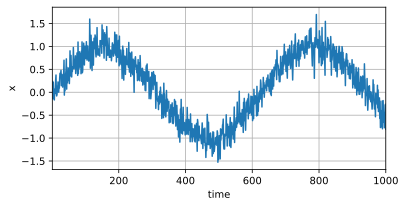

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 50, 0.01)

epoch 1, loss: 0.068319
epoch 2, loss: 0.055229
epoch 3, loss: 0.052931
epoch 4, loss: 0.050721
epoch 5, loss: 0.050118
epoch 6, loss: 0.050064
epoch 7, loss: 0.051576
epoch 8, loss: 0.049481
epoch 9, loss: 0.049702
epoch 10, loss: 0.053598
epoch 11, loss: 0.048244
epoch 12, loss: 0.049048
epoch 13, loss: 0.050276
epoch 14, loss: 0.048294
epoch 15, loss: 0.052574
epoch 16, loss: 0.049231
epoch 17, loss: 0.048068
epoch 18, loss: 0.050888
epoch 19, loss: 0.048185
epoch 20, loss: 0.047843
epoch 21, loss: 0.057227
epoch 22, loss: 0.048554
epoch 23, loss: 0.048039
epoch 24, loss: 0.057943
epoch 25, loss: 0.049393
epoch 26, loss: 0.047937
epoch 27, loss: 0.048871
epoch 28, loss: 0.050517
epoch 29, loss: 0.050696
epoch 30, loss: 0.048913
epoch 31, loss: 0.050525
epoch 32, loss: 0.048465
epoch 33, loss: 0.048485
epoch 34, loss: 0.048211
epoch 35, loss: 0.051942
epoch 36, loss: 0.049232
epoch 37, loss: 0.051131
epoch 38, loss: 0.050985
epoch 39, loss: 0.048677
epoch 40, loss: 0.050489
epoch 41,

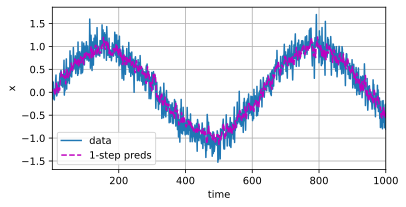

In [6]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

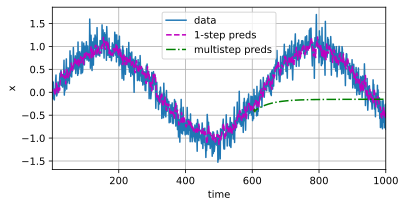

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

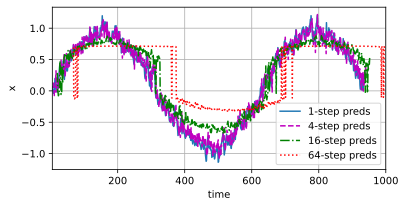

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))